# ILOVIEW
**I**NTERACTIVE **L**IGHTWEIGHT **O**MNI **VIEW**ER

------------------------------------------------
## Tutorial

In this tutorial, we'll look at ways of using the simple viewer to explore diverse types of data. Let's start by importing some libraries.

In [1]:
from iloview import viewer
import nibabel as nib
import pandas as pd

First, let's show an empty viewer.

In [2]:
v = viewer.ILOViewer()
v.show()

A 3D array like scalar image can be displayed using an interactive slicer. Using nibabel, let's load a FA map, and add it to the viewer. Once the viewer as shown, try interacting with the camera using the mouse or the keypad. Then, with the interactive widget, try reslicing the image by first pressing the key "i". Finally, we'll get a snapshot of the view juste before the viewer window has been closed.

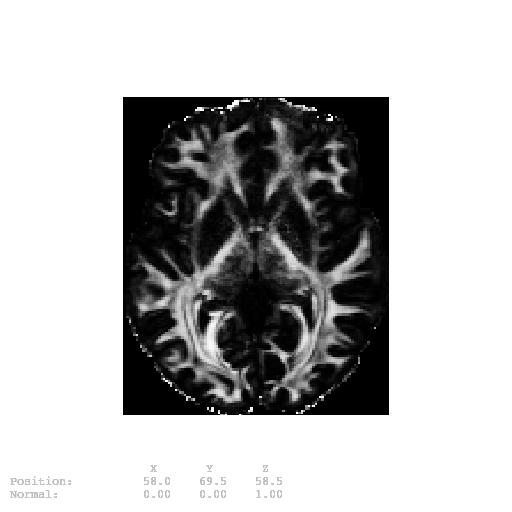

In [3]:
fa = nib.load("data/fa.nii.gz")
v = viewer.ILOViewer(fa.get_fdata())
v.show()
v.snapshot(rem_bckgd=True)

Nice! Thanks to the IPython Notebook integration, we can see the results inline. Also, a list of the available interactive hotkeys can be obtained using the `help` method.

In [4]:
v.help()

Keyboard Actions
----------------
Shift-a ..................Set camera (and plane) angle to Axial
Shift-c ..................Set camera (and plane) angle to Coronal
Shift-s ..................Set camera (and plane) angle to sagittal
e ........................Exit
f ........................fly to the picked point
i ........................Toggle interaction with plane widget
j ........................switch to joystick mode
> ........................Select next slice
Control-> ................Select next slice (big step)
p ........................Pick (select) object under pointer
z ........................Set plane angle to Axial
y ........................Set plane angle to Coronal
x ........................Set plane angle to sagittal
s ........................Show geometry as planes
< ........................Select previous slice
Control-< ................Select previous slice (big step)
q ........................Quit
9 ........................Rotate scene clockwise
7 ..................

Now, let's explore other types of objects. Let's reset the scene, load a tractogram file, and add it to the viewer.

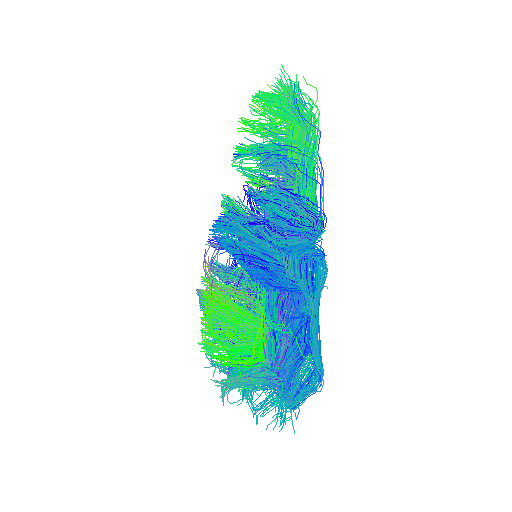

In [5]:
v = viewer.ILOViewer()
af = nib.streamlines.load("data/prob_int_af_left.trk")
v.streamlines(af.streamlines[:2000])
v.show()
v.snapshot(rem_bckgd=True)

We might also want to add several streamline bundles to the existing scene by

- coloring one of them with a FA map,
- coloring an other in yellow and as tubes, and
- displaying the points of each streamline

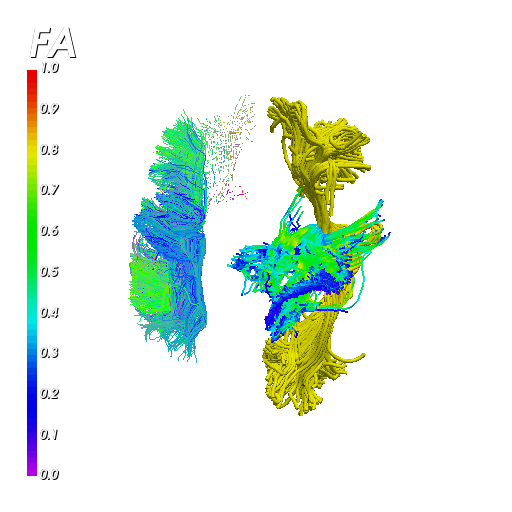

In [6]:
cst = nib.streamlines.load("data/prob_int_cst_right.trk")
v.streamlines(cst.streamlines[:1000], color=fa.get_fdata(),
                   color_name= "FA", color_affine=fa.affine,
                   width=2)
ifof = nib.streamlines.load("data/prob_int_ifof_right.trk")
v.streamlines(ifof.streamlines[:1000], color=[1, 1, 0],
                   tube=True, width=1.0)
uf = nib.streamlines.load("data/prob_int_uf_left.trk")
v.streamlines(uf.streamlines[:1000], show_points=True)
v.show()
v.snapshot(rem_bckgd=True)

Now, let's start from scratch again adding reference arrows at the origin, let's put some streamtubes and move the camera for a better framing. Then, let's also add an annotation, and save that shot in a file in high resolution (4 times the specified render size), without the background.

Note: To view the snapshot inline, you must call snapshot on the last line and without specifying the filename.

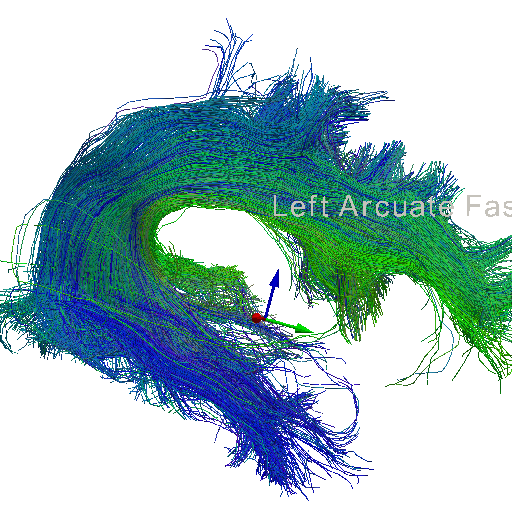

In [7]:
v = viewer.ILOViewer(origin=True)
v.streamlines(af.streamlines[:5000], tube=True)
v.set_camera_angle("sagittal")
v.move_camera(azimuth=15)
v.move_camera(roll=-15)
v.move_camera(zoom=1.7)
v.annotation("Left Arcuate Fasciculus", [-20, -10, 20], 4)
v.show()
v.snapshot(
    snapshot_fn="my_af_shot.png",
    render_size=(1920, 1080),
    res_factor=4,
    rem_bckgd=True)
v.snapshot(rem_bckgd=True)

Here, let's show a RGB FA image along with the streamline binary mask of the IFOF, both with some transparency and double accuracy.

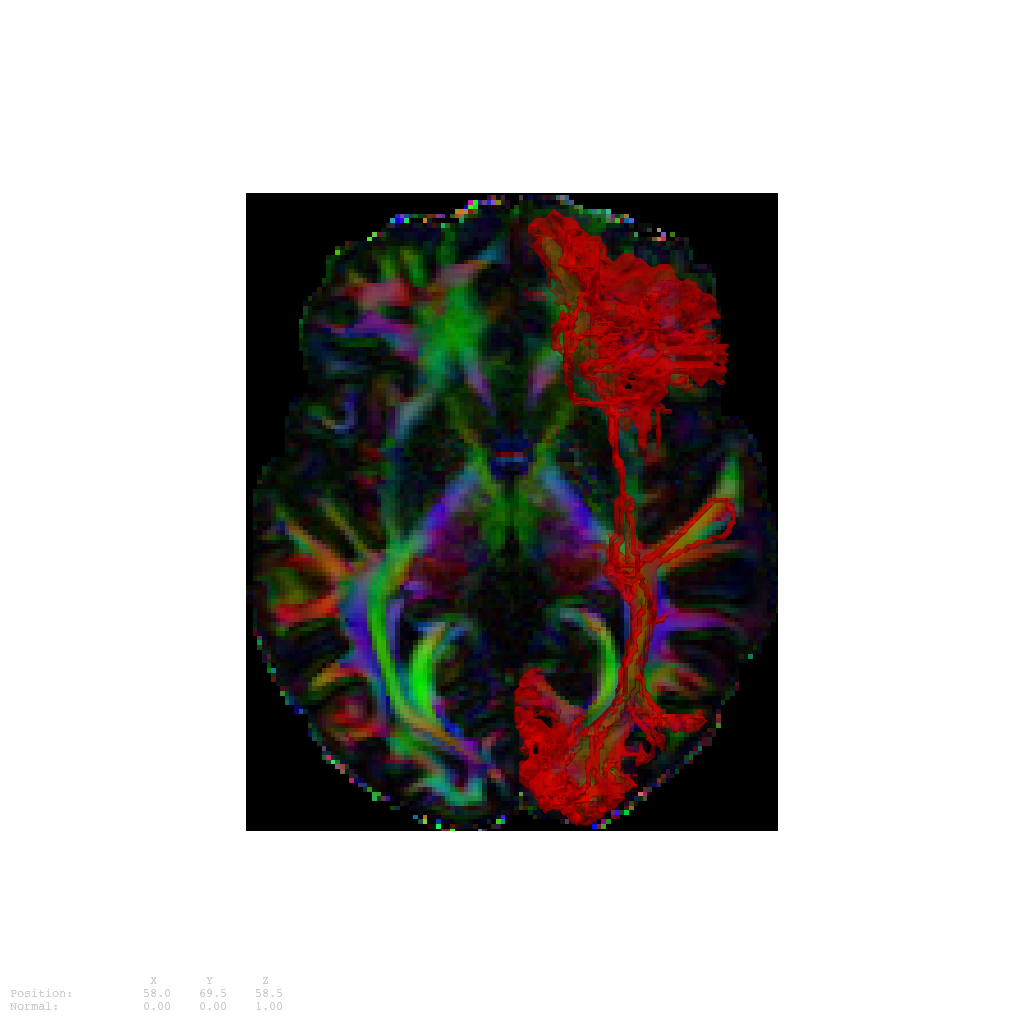

In [8]:
rgb = nib.load("data/rgb.nii.gz")
v = viewer.ILOViewer(rgb.get_fdata(),
                           opacity=0.75)
ifof_mask = nib.load("data/prob_int_ifof_right_mask.nii.gz")
v.roi(ifof_mask.get_fdata(),
           opacity=0.5)
v.show()
v.snapshot(rem_bckgd=True, res_factor=2)

ILOView can also show a list of labels in an image. For demonstration, let's take the white matter parcellation from FreeSurfer. Using Pandas, let's read and select some regions of the parcellation. Then, label names are going to be used for identification. Also, FreeSurfer colors are going to be used, by first normalizing them between 0 and 1, and associating them to their respective label as tuples. In the scene, let's put the T1 image by clipping off extreme values, then add the labels.

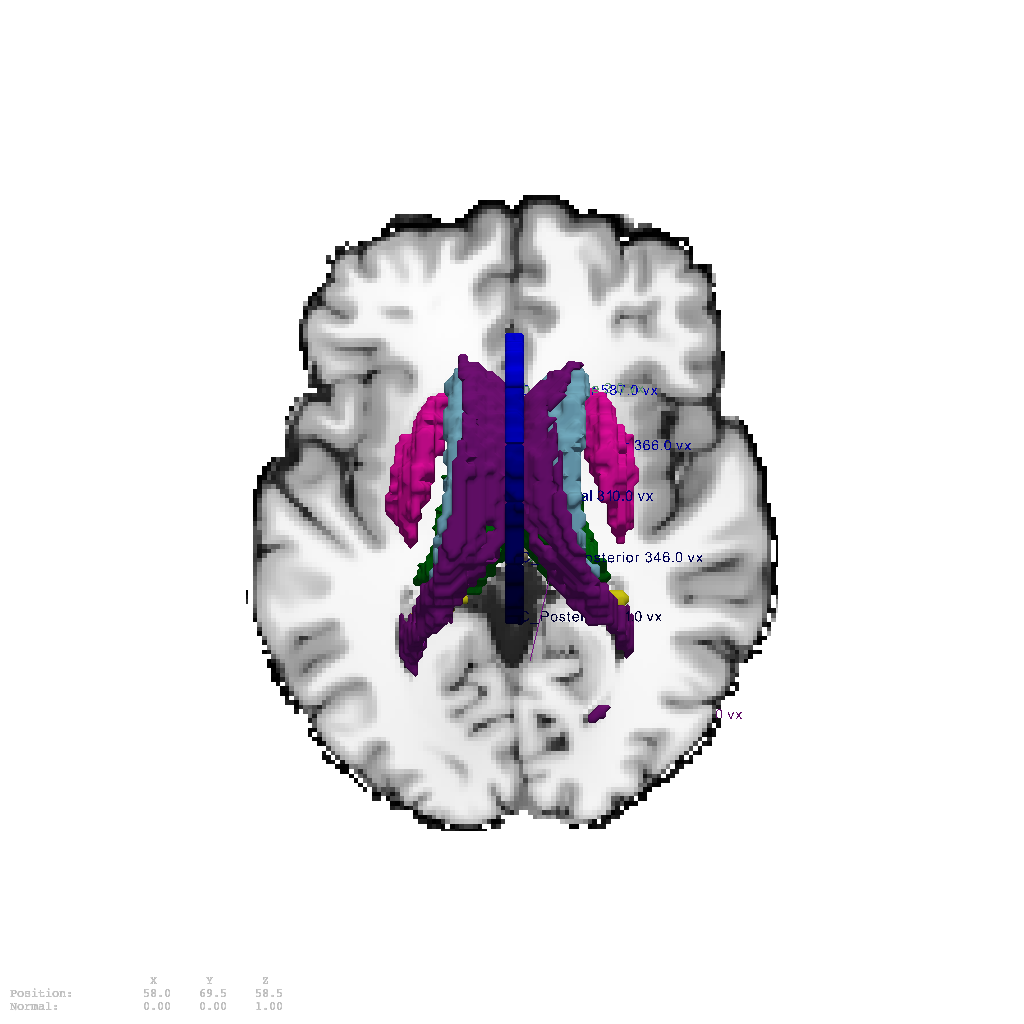

In [9]:
fs_lut = pd.read_csv("data/freesurfer_lut.csv", index_col=0)
fs_lut = fs_lut[
    fs_lut["name"].str.contains("CC") |
    fs_lut["name"].str.contains("Thalamus") |
    fs_lut["name"].str.contains("Ventricle") |
    fs_lut["name"].str.contains("Caudate") |
    fs_lut["name"].str.contains("Putamen") |
    fs_lut["name"].str.contains("Amygdala") |
    fs_lut["name"].str.contains("Vessel") |
    fs_lut["name"].str.contains("Amygdala") |
    fs_lut["name"].str.contains("Hippocampus") |
    fs_lut["name"].str.contains("Insula") |
    fs_lut["name"].str.contains("Operculum") |
    fs_lut["name"].str.contains("Stem")]
labels = fs_lut["name"].to_dict()
for c in ["r", "g", "b"]:
    fs_lut[c] = fs_lut[c] / 255.0
colors = fs_lut.apply(
    lambda x: (x["r"], x["g"], x["b"]), axis=1).to_dict()
t1 = nib.load("data/T1w.nii.gz")
v = viewer.ILOViewer(t1.get_fdata(), clip=[50, 1000])
wmparc = nib.load("data/wmparc.nii.gz")
v.labels(wmparc.get_fdata(),
         labels=labels,
         colors=colors)
v.show()
v.snapshot(rem_bckgd=True, res_factor=2)

For the grand finale, let's use scalar and geometric features together in world space, by specifying the affine transformation for the T1 image and the white matter ROI. Also, note the use of the level argument specifying which label of interest to display as a ROI.

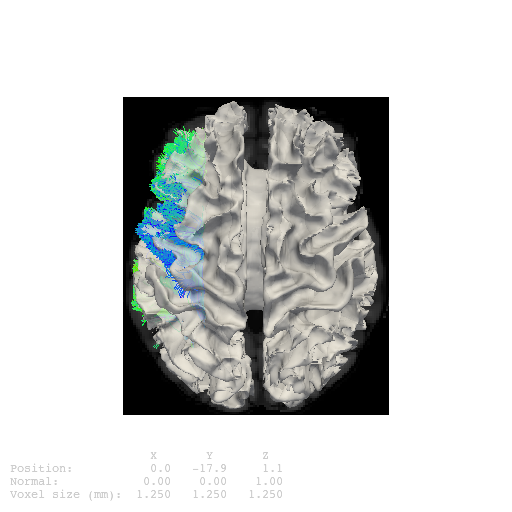

In [10]:
v = viewer.ILOViewer(t1.get_fdata(), t1.affine)
seg = nib.load("data/seg_csf_wm_gm.nii.gz")
v.roi(seg.get_fdata(), seg.affine, level=3, color=[1,1,1],
      opacity=0.75, smooth=True)
v.streamlines(af.streamlines[0:10000])
v.show()
v.snapshot(rem_bckgd=True)

Several other parameters exist and are yours to explore. Simply refer to the ILOViewer methods headers or simply call a functions help like the following.

In [11]:
viewer.ILOViewer.streamlines?

Signature:
viewer.ILOViewer.streamlines(
    self,
    streamlines,
    color=None,
    color_affine=None,
    color_name='Streamlines',
    lut=None,
    tube=False,
    optiview=False,
    width=None,
    show_scalar_bar=True,
    show_points=False,
)
Docstring: Adds streamlines to the viewer.
File:      ~/work/iloview/iloview/viewer.py
Type:      function

The viewer can be called from terminal with the command `iloview` with basic features for quick and easy visualization. (Omit the "!" when using the terminal)

In [12]:
! iloview \
    -v data/T1w.nii.gz \
    -t data/prob_int_uf_left.trk \
    --roi data/prob_int_ifof_right_mask.nii.gz